## EXIF Wrapped

Analyzer for photo metadata -- Summarize your photo-taking habits

In [67]:
# Import basics
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL.ExifTags import TAGS

### Quickstart: Define local variables

1. Set `camera_model` to the name of your camera, including any spaces necessary (not case sensitive). 
2. Set the `directory` to the base folder of where your images are located.
    - Hint: Change directory `cd` to the deepest/innermost (child-most) folder that still contains *all* of your photos. Use `pwd` to display the path to that directory, and set it to `directory`.
3. (*optional*) Set `output_dir` to save your data to .csv format and plots as images. 

After completion of the above, hit `Run All` and you should see your results at the bottom!

In [68]:
camera_model = 'Nikon Z 5'
directory = '/Users/derekzheng/Pictures/Lightroom Saved Photos'
output_dir = '/Users/derekzheng/Documents/Code/dz-img-analysis'
other_cameras_found = set()

In [69]:
def get_exif_data(image_path):
    image = Image.open(image_path)
    exif_data = {}
    info = image._getexif()
    if info:
        for tag_id, value in info.items():
            tag = TAGS.get(tag_id, tag_id)
            exif_data[tag] = value
    return exif_data

In [70]:
def analyze_photos(directory, camera_model=None):
    data = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as image:
                        exif_data = {}
                        info = image._getexif()
                        if info:
                            for tag_id, value in info.items():
                                tag = TAGS.get(tag_id, tag_id)
                                exif_data[tag] = value

                        if camera_model and exif_data.get('Model').lower() != camera_model.lower():
                            # print(f"Skipping, file {file}, is from {exif_data.get('Model')}")
                            other_cameras_found.add(exif_data.get('Model'))
                            continue

                        focal_length = exif_data.get('FocalLength', (0, 1))
                        focal_length = focal_length[0] / focal_length[1] if isinstance(
                            focal_length, tuple) else focal_length

                        aperture = exif_data.get('FNumber', (0, 1))
                        aperture = aperture[0] / aperture[1] if isinstance(
                            aperture, tuple) else aperture

                        iso = exif_data.get('ISOSpeedRatings')

                        shutter_speed = exif_data.get('ExposureTime', (0, 1))
                        shutter_speed = shutter_speed[0] / shutter_speed[1] if isinstance(
                            shutter_speed, tuple) else shutter_speed

                        data.append({
                            'Focal Length': focal_length,
                            'Aperture': aperture,
                            'ISO': iso,
                            'Shutter Speed': shutter_speed
                        })
                except Exception as e:
                    print(f"Error processing {file}: {str(e)}")

    return pd.DataFrame(data)

In [71]:
df_cache = analyze_photos(directory, camera_model)

Error processing headshot-casual.jpg: 'NoneType' object has no attribute 'lower'
Error processing N49797008025-R1-041-19.jpg: 'NoneType' object has no attribute 'lower'
Error processing N49797008025-R1-035-16.jpg: 'NoneType' object has no attribute 'lower'
Error processing N49797008025-R1-041-19.jpg: 'NoneType' object has no attribute 'lower'
Error processing N49797008025-R1-035-16.jpg: 'NoneType' object has no attribute 'lower'
Error processing DSC_7174.jpg: 'NoneType' object has no attribute 'lower'


In [72]:
df_cache.columns

Index(['Focal Length', 'Aperture', 'ISO', 'Shutter Speed'], dtype='object')

In [73]:
from fractions import Fraction

def rational_to_float(value):
    if isinstance(value, tuple) and len(value) == 2:
        return value[0] / value[1]
    return float(value)

df_new = df_cache.copy()

# Convert columns to float
for column in ['Focal Length', 'Aperture', 'ISO', 'Shutter Speed']:
    df_new[column] = df_new[column].apply(rational_to_float)

# Now calculate statistics
columns = df_new.columns

for column in columns:
    print(f"\nStatistics for {column}:")
    
    # Mean
    mean = df_new[column].mean()
    print(f"Mean: {mean:.2f}")
    
    # Mode
    mode = df_new[column].mode().values
    if len(mode) == 1:
        print(f"Mode: {mode[0]:.2f}")
    else:
        print(f"Mode: {', '.join([f'{m:.2f}' for m in mode])}")
    
    # Median
    median = df_new[column].median()
    print(f"Median: {median:.2f}")


Statistics for Focal Length:
Mean: 41.89
Mode: 24.00
Median: 42.00

Statistics for Aperture:
Mean: 5.36
Mode: 4.00
Median: 4.00

Statistics for ISO:
Mean: 1113.16
Mode: 100.00
Median: 200.00

Statistics for Shutter Speed:
Mean: 0.05
Mode: 0.01
Median: 0.01


In [76]:
def plot(directory, camera_model=None, output_dir=None):
    print(f"Analyzing photos in: {directory}")
    if camera_model:
        print(f"Filtering for camera model: {camera_model}")
    
    df = df_new
    
    if df.empty:
        print("No photos found matching the criteria.")
        return
    
    print(f"Processed {len(df)} photos.")
    print(f"Other cameras found: {other_cameras_found}")
    
    # Calculate statistics
    stats = df.describe(include='all')
    print("\nStatistics:")
    print(stats)

        # Plot histograms
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    df['Focal Length'].hist(ax=axs[0, 0], bins=20)
    axs[0, 0].set_title('Focal Length Distribution')
    axs[0, 0].set_xlabel('Focal Length (mm)')
    
    df['Aperture'].hist(ax=axs[0, 1], bins=20)
    axs[0, 1].set_title('Aperture Distribution')
    axs[0, 1].set_xlabel('Aperture (f-number)')
    
    df['ISO'].hist(ax=axs[1, 0], bins=20)
    axs[1, 0].set_title('ISO Distribution')
    axs[1, 0].set_xlabel('ISO')
    
    df['Shutter Speed'].hist(ax=axs[1, 1], bins=20)
    axs[1, 1].set_title('Shutter Speed Distribution')
    axs[1, 1].set_xlabel('Shutter Speed (seconds)')
    
    plt.tight_layout()
    
    if output_dir:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        plt.savefig(os.path.join(output_dir, 'photo_stats.png'))
        df.to_csv(os.path.join(output_dir, 'photo_data.csv'), index=False)
        stats.to_csv(os.path.join(output_dir, 'photo_stats.csv'))
    else:
        plt.show()

In [51]:
df_aperature = df_new['Aperture'].copy()
df_aperature.head()

upper_trim_value = 4.0
df_aperature = df_aperature[df_aperature < upper_trim_value]

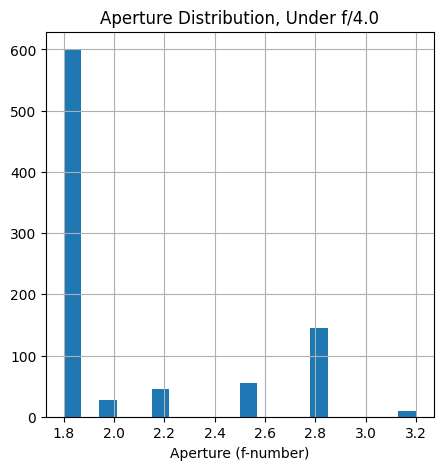

In [79]:
plt.figure(figsize=(5,5))
df_aperature.hist(bins=20)
plt.title(f'Aperture Distribution, Under f/{upper_trim_value}')
plt.xlabel('Aperture (f-number)')

plt.show()

Analyzing photos in: /Volumes/DZ IMG EVO/dz img
Filtering for camera model: NIKON Z 5
Processed 14901 photos.
Other cameras found: {'X100V', 'iPhone 12 Pro', None, 'iPhone 15 Pro', 'HERO9 Black\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'NIKON D7100', 'FC7303\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', 'FC7303'}

Statistics:
       Focal Length      Aperture           ISO  Shutter Speed
count  14901.000000  14901.000000  14846.000000   14901.000000
mean      49.808067      5.573894   1379.244241       0.022719
std       16.392313      2.518309   4318.737786       0.095575
min       24.000000      1.800000     50.000000       0.000125
25%       35.000000      4.000000    100.000000       0.002500
50%       50.000000      4.500000    100.000000       0.004000
75%       70.000000      7.100000    400.000000       0.010000
max       70.000000     22.000000  51200.000000       1.000000


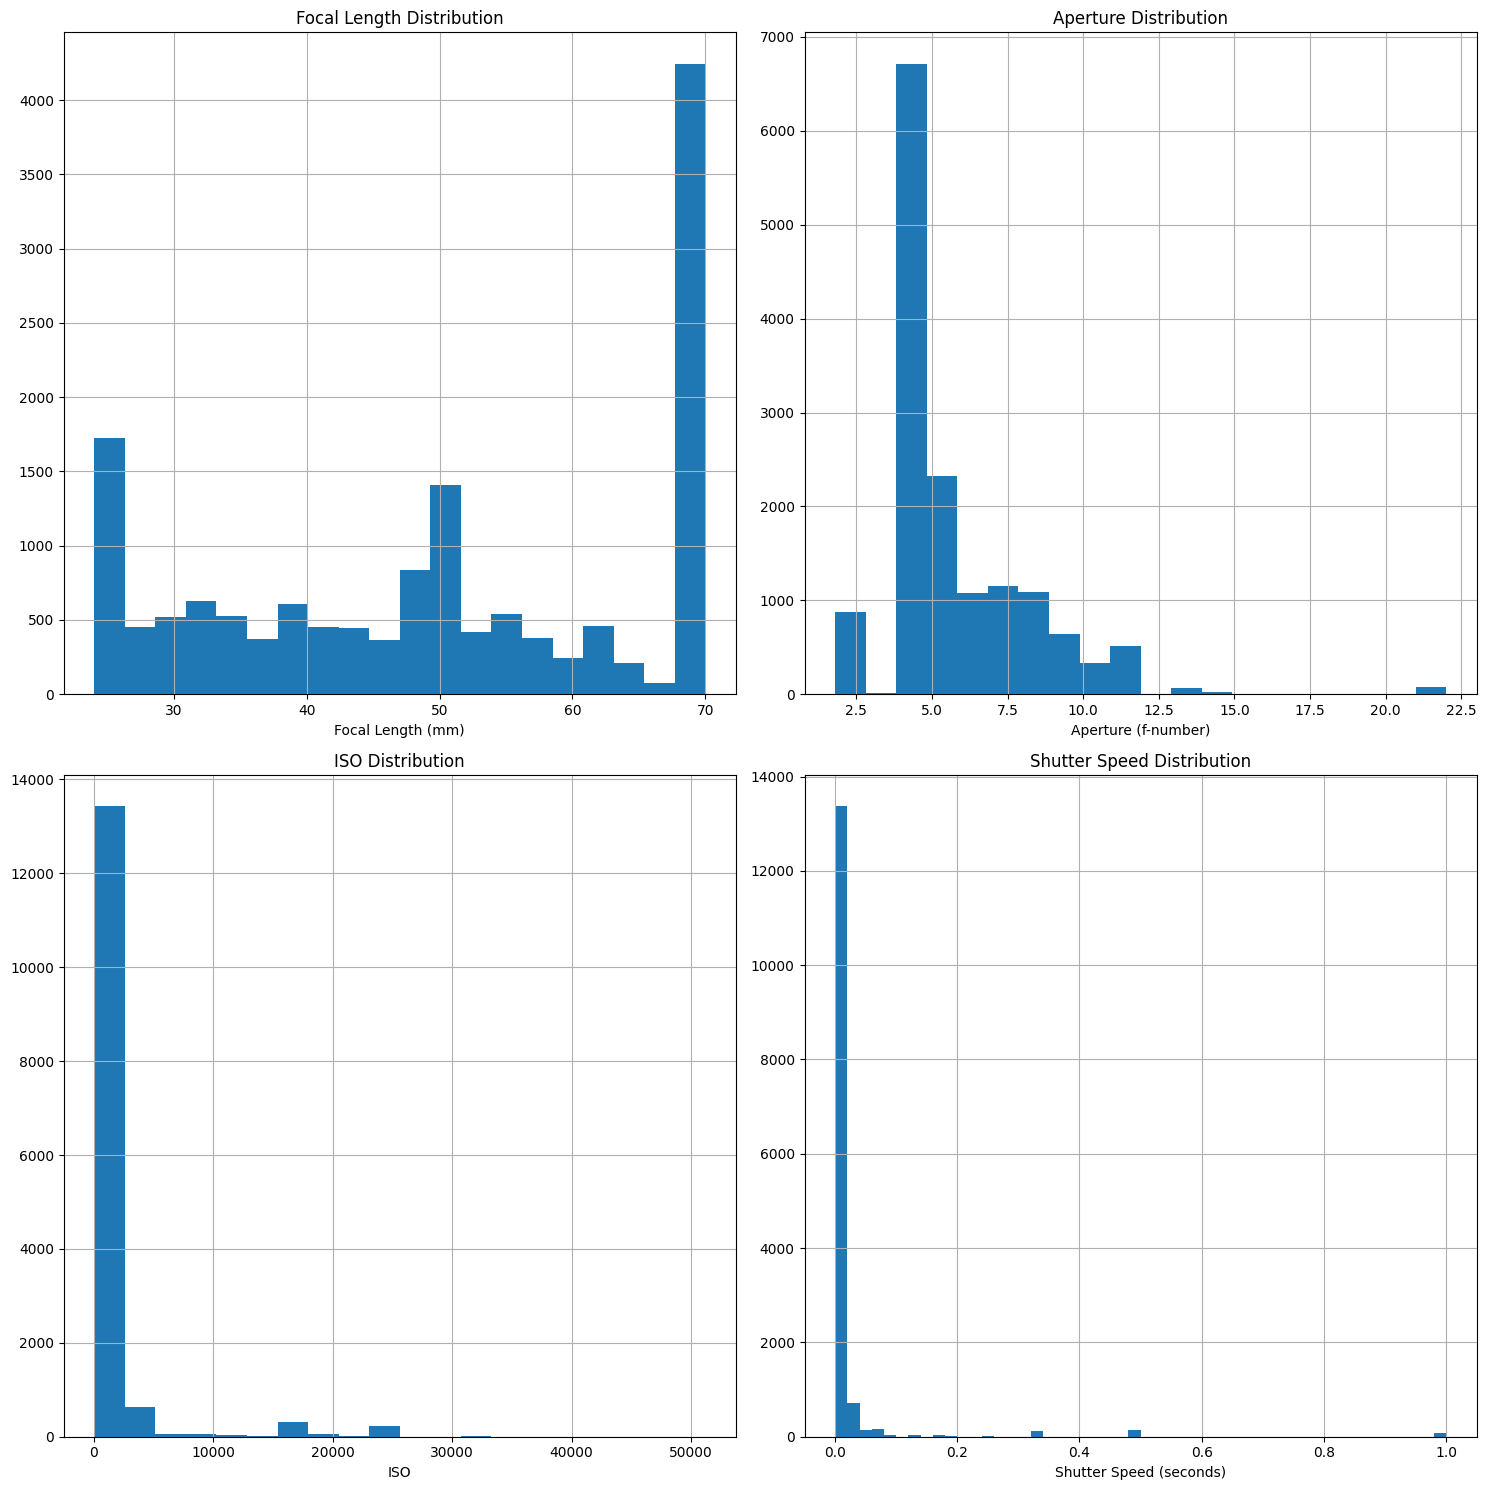

In [28]:
plot(directory, camera_model=camera_model, output_dir=None)